In [1]:
%matplotlib inline

import imageio
import scipy.stats
import scipy.special

import numpy as np
import pandas as pd
from numpy import array as arr

import os
import re
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from astropy.io import fits

from scipy.stats import sem 
from scipy import ndimage as ndi
from scipy.optimize import curve_fit

import sys
sys.path.append('../../Analysis_code/klab_python_lib/')

import klib

### Can comment below if not editing klib
%load_ext autoreload
%aimport klib
%autoreload

In [9]:
from typing import Optional
import cv2
from pymba import Vimba, VimbaException, Frame
import time

# todo add more colours
PIXEL_FORMATS_CONVERSIONS = {
    'BayerRG8': cv2.COLOR_BAYER_RG2RGB,
}


def display_frame(frame: Frame, delay: Optional[int] = 1) -> None:
    """
    Displays the acquired frame.
    :param frame: The frame object to display.
    :param delay: Display delay in milliseconds, use 0 for indefinite.
    """
    print('frame {}'.format(frame.data.frameID))

    # get a copy of the frame data
    image = frame.buffer_data_numpy()

    plt.imshow(image)
    plt.show()
#     # convert colour space if desired
#     try:
#         image = cv2.cvtColor(image, PIXEL_FORMATS_CONVERSIONS[frame.pixel_format])
#     except KeyError:
#         pass

#     # display image
#     cv2.imshow('Image', image)
#     cv2.waitKey(delay)

def print_camera_options(cameraID):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()

        # get feature value via feature object
        for feature_name in camera.feature_names():
            feature = camera.feature(feature_name)

            try:
                value = feature.value
                range_ = feature.range

                # alternatively the feature value can be read as an object attribute
                # value = getattr(camera, feature_name)
                # or
                # value = camera.someFeatureName

            except VimbaException as e:
                value = e
                range_ = None

            print('\n\t'.join(
                str(x) for x in (
                    feature_name,
                    'value: {}'.format(value),
                    'range: {}'.format(range_))
                if x is not None))

        camera.close()
    
def print_ids():
    with Vimba() as vimba:
        print(vimba.camera_ids())
        
def capture_image(cameraID):
    with Vimba() as vimba:
        camera = vimba.camera(cameraID)
        camera.open()

        camera.feature('TriggerSource').value = 'Software'
        camera.feature('TriggerSelector').value = 'FrameStart'
        camera.feature('AcquisitionFrameRateMode').value = 'Off'
        camera.feature('ExposureMode').value = 'Timed'
        camera.feature('ExposureTime').value = 40
        camera.feature('TriggerMode').value = 'Off'

        camera.arm('SingleFrame')
        # capture a single frame, more than once if desired
        for i in range(1):
            try:
                frame = camera.acquire_frame()
            except VimbaException as e:
                # rearm camera upon frame timeout
                if e.error_code == VimbaException.ERR_TIMEOUT:
                    print(e)
                    camera.disarm()
                    camera.arm('SingleFrame')
                else:
                    raise
        image = frame.buffer_data_numpy()
        camera.disarm()
        camera.close()
        np.savetxt('tmp_img.txt', image, fmt='%d')
        plt.imshow(image)

In [10]:
print_ids()
# print_camera_options()

['DEV_1AB228000566', 'DEV_1AB2280006D0']


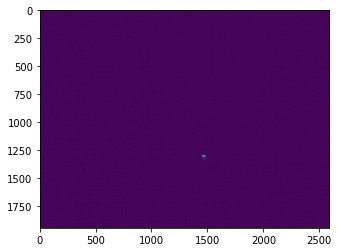

In [11]:
capture_image(1)

In [13]:
img = np.loadtxt('tmp_img.txt', dtype=int);

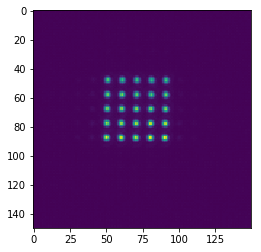

In [22]:
plt.imshow(img[1250:1400,1400:1550])

In [2]:
with Vimba() as vimba:
    camera = vimba.camera(1)
    camera.open()

    camera.feature('TriggerSource').value = 'Software'
    camera.feature('TriggerSelector').value = 'FrameStart'
    camera.feature('AcquisitionFrameRateMode').value = 'Off'
    camera.feature('ExposureMode').value = 'Timed'
    camera.feature('ExposureTime').value = 50000
    camera.feature('TriggerMode').value = 'Off'

    camera.arm('SingleFrame')
    # capture a single frame, more than once if desired
    for i in range(1):
        try:
            frame = camera.acquire_frame()
            image = frame.buffer_data_numpy()
        except VimbaException as e:
            # rearm camera upon frame timeout
            if e.error_code == VimbaException.ERR_TIMEOUT:
                print(e)
                camera.disarm()
                camera.arm('SingleFrame')
            else:
                raise
    camera.disarm()
    camera.close()

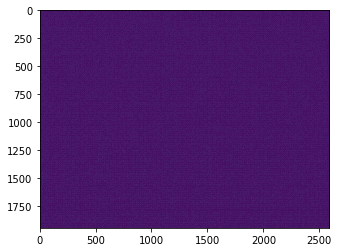

In [5]:
plt.imshow(image)